In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as scipy
sys.path.append("..\\backtesting\\utils")
import dynamic_backtesting as db
plt.style.use('seaborn')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["black", "green",  "deepskyblue", "orange","grey", "lime", "purple", "Gold", "brown", "blue", "pink"]) 

In [ ]:
assets = {"EEM": "Emerging Markets",
           "IVV": "S&P 500",
           "IEV": "MSCI Europe",
           "IXN": "Global Tech",
           "IYR": "US Real Estate",
           "IXG": "Global Financials",
           "EXI": "Global Industrials",
           "GC=F": "Gold Futures", 
           "BZ=F": "Brent Crude Oil Futures",
           "HYG": "High-Yield Corporate Bonds",
           "TLT": "20+ Year Treasury Bonds"}
tickers = list(assets.keys())
asset_names = list(assets.values())
#spx = pd.read_csv('../data/spx.csv').stack().tolist()

**Henter return data udfra tickers**

In [ ]:
return_data =db.download_return_data(["IVV","BZ=F","TLT"])
#laver ny dictionary
included_asset = {asset: assets[asset] for asset in return_data.columns.to_list() }

**Henter parametre**

In [ ]:
def GARCH_MODEL(tickers,ugarch_model="sGARCH", garch_order=(1, 1)):
    """
    Estimate af GARCH model and parse parameters, sigmas and residuals
    ugarch_model: sGARCH, gjrGARCH
    garch_order: (1, 1), (1,0)
    """
    coef, residuals, sigmas = db.fit_garch_model(tickers=tickers,ugarch_model=ugarch_model,garch_order=garch_order)
    return coef, residuals, sigmas

**Laver data til IRF plot**

In [ ]:
def IRF_maker(GARCHTYPE,t,Asset_number,shock_size, coef, residuals, sigmas):
    """
    Makes data for an IRF plot with a GARCH type model using the data in the csv file and simulation

    Variables:
    t (int): the length of sample
    Asset_number: The asset that receive the shock
    shock_size: the stock to the mean
    GARCHTYPE: sGARCH11, sGARCH10, gjrGARCH11
    Residuals: Past residuals
    Sigmas: Past sigmas
    """
    #unpacks paramters
    params_dict = db.parse_garch_coef(coef, np.shape(residuals)[1], GARCHTYPE)
    print(params_dict["kappa"])
    print(params_dict["alpha"])
    mu_T=params_dict["mu"].transpose()
    irf_data=pd.DataFrame(mu_T.repeat(t,axis=0),columns=included_asset)
    #Indsætter chok
    irf_data.iloc[int(t/2),Asset_number]=shock_size
    #udregner omega
    irf_omega_s=db.calc_Omega_ts(irf_data,irf_data,sigmas,residuals,**params_dict)
    irf_sigma_s=pd.DataFrame([np.diag(Omega) for Omega in db.remove_Omega_timestamp(irf_omega_s)],columns=included_asset)
    irf_sigma_s.index=irf_sigma_s.index-int(t/2)+1
    #udregner vægte
    irf_weights=pd.DataFrame(db.calc_weights_garch_no_trading_cost(irf_omega_s),columns=included_asset)
    irf_weights.index=irf_weights.index-int(t/2)
    return irf_weights,irf_sigma_s

**Laver figur for ARCH(1)**

In [ ]:
coef_ARCH, residuals_ARCH, sigmas_ARCH= GARCH_MODEL(["IVV","BZ=F","TLT"],"sGARCH",(1,0))

In [ ]:
irf_weights_ARCH,irf_sigma_ARCH=IRF_maker("sGARCH10",10000,0,-2,coef_ARCH, residuals_ARCH, sigmas_ARCH)

In [ ]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.plot(irf_weights_ARCH)
ax.set_ylim(0.0,0.85)
ax.set_xlim(-5,50)
ax.legend(included_asset.values(), loc='upper right')
ax.set_xlabel('Period, $t$') 
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -78) 
fig.savefig("IRF_ARCH(1)_weight.png", bbox_inches = 'tight', pad_inches = 0.1)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax1.plot(np.sqrt(irf_sigma_ARCH))
ax1.set_ylim(0.7,2.4)
ax1.set_xlim(-5,50)
ax1.legend(included_asset.values(), loc='upper right')
ax1.set_xlabel('Period, $t$') 
ax1.set_ylabel('Volatility, $\sigma_t$',loc='top', rotation = 0, labelpad = -78)
fig1.savefig("IRF_ARCH(1)_vol.png", bbox_inches = 'tight', pad_inches = 0.1)

**Laver figur til GARCH(1,1)**

In [ ]:
coef_GARCH, residuals_GARCH, sigmas_GARCH= GARCH_MODEL(["IVV","BZ=F","TLT"],"sGARCH",(1,1))

In [ ]:
irf_weights_GARCH,irf_sigma_GARCH=IRF_maker("sGARCH11",10000,0,-2,coef_GARCH, residuals_GARCH, sigmas_GARCH)

In [ ]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.plot(irf_weights_GARCH)
ax.set_ylim(0,0.7)
ax.set_xlim(-5,100)
ax.legend(included_asset.values(), loc='upper right')
ax.set_xlabel('Period, $t$') 
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -72) 
fig.savefig("IRF_GARCH(1,1)_weight.png", bbox_inches = 'tight', pad_inches = 0.1)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax1.plot(np.sqrt(irf_sigma_GARCH))
ax1.set_xlim(-5,100)
ax1.set_ylim(0.3,1)
ax1.legend(included_asset.values(), loc='upper right')
ax1.set_xlabel('Period, $t$') 
ax1.set_ylabel('Volatility, $\sigma_t$',loc='top', rotation = 0, labelpad = -78) 
fig1.savefig("IRF_GARCH(1,1)_vol.png", bbox_inches = 'tight', pad_inches = 0.1)

**Laver figur til GJR-GARCH(1,1) med et negativt stød**

In [ ]:
coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH= GARCH_MODEL(["IVV","BZ=F","TLT"],"gjrGARCH",(1,1))

In [ ]:
irf_weights_GJRGARCH,irf_sigma_GJRGARCH=IRF_maker("gjrGARCH11",10000,0,-2,coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH)

In [ ]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.plot(irf_weights_GJRGARCH)
ax.set_ylim(0,0.7)
ax.set_xlim(-5,100)
ax.legend(included_asset.values(), loc='upper right')
ax.set_xlabel('Period, $t$') 
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -72)
fig.savefig("IRF_GJRGARCH(1,1)_vol.png", bbox_inches = 'tight', pad_inches = 0.1)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax1.plot(np.sqrt(irf_sigma_GJRGARCH))
ax1.set_xlim(-5,100)
ax1.set_ylim(0.3,1.5)
ax1.legend(included_asset.values(), loc='upper right')
ax1.set_xlabel('Period, $t$') 
ax1.set_ylabel('Volatility, $\sigma_t$',loc='top', rotation = 0, labelpad = -78) 
fig1.savefig("IRF_GJRGARCH(1,1)_weight.png", bbox_inches = 'tight', pad_inches = 0.1)

**Samme som ovenstående, men med positivt stød**

In [ ]:
irf_weights_GJRGARCH_p,irf_sigma_GJRGARCH_p=IRF_maker("gjrGARCH11",10000,0,2,coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.plot(irf_weights_GJRGARCH_p)
ax.set_ylim(0,0.7)
ax.set_xlim(-5,100)
ax.legend(included_asset.values(), loc='upper right')
ax.set_xlabel('Period, $t$') 
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -72)
fig.savefig("IRF_GJRGARCH(1,1)_p_vol.png", bbox_inches = 'tight', pad_inches = 0.1)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax1.plot(np.sqrt(irf_sigma_GJRGARCH_p))
ax1.set_xlim(-5,100)
ax1.set_ylim(0.3,1.5)
ax1.legend(included_asset.values(), loc='upper right')
ax1.set_xlabel('Period, $t$') 
ax1.set_ylabel('Volatility, $\sigma_t$',loc='top', rotation = 0, labelpad = -78) 
fig1.savefig("IRF_GJRGARCH(1,1)_p_weight.png", bbox_inches = 'tight', pad_inches = 0.1)

**Ubetinget vægte til sammenligning**

In [ ]:
Assets_u=["IVV","TLT"]

In [ ]:
v_t_ARCH, out_of_sample_s_ARCH_s, in_sample_s_ARCH_s, Omega_t_ARCH_s = db.garch_no_trading_cost(Assets_u, number_of_out_of_sample_days=4*250, model_type="sGARCH10") 
included_asset_arch = {asset: assets[asset] for asset in v_t_ARCH.columns.to_list() }

In [ ]:
v_t_GARCH, out_of_sample_s_GARCH_s, in_sample_s_GARCH_s,Omega_t_GARCH_s = db.garch_no_trading_cost(Assets_u, number_of_out_of_sample_days=4*250, model_type="sGARCH11")
included_asset_garch = {asset: assets[asset] for asset in v_t_GARCH.columns.to_list() }

In [ ]:
v_t_UC= db.unconditional_weights(tickers=Assets_u, number_of_out_of_sample_days=4*250)

**Laver figurer**

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.set_prop_cycle(matplotlib.cycler(color=["black", "green"]))

ax.plot(v_t_ARCH,linewidth=0.5)
ax.plot(v_t_UC,linewidth=2, linestyle='--')
ax.set_ylim(0,1)
ax.legend(included_asset_arch.values(),ncol=3,loc="upper left")
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -78) 
fig.savefig("ARCH_weight_unconditional.png", bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.set_prop_cycle(matplotlib.cycler(color=["black", "green"]))
ax.plot(v_t_GARCH,linewidth=0.5)
ax.plot(v_t_UC,linewidth=2, linestyle='--')
ax.set_ylim(0,1)
ax.legend(included_asset_garch.values(),ncol=3,loc="upper left")
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -78) 
fig.savefig("GARCH_weight_unconditional.png", bbox_inches = 'tight', pad_inches = 0.1)

**IRF plots with transaction cost**

In [ ]:
return_data_TC =db.download_return_data(["IVV","BZ=F","TLT"])
#laver ny dictionary
included_asset_TC = {asset: assets[asset] for asset in return_data_TC.columns.to_list() }

In [ ]:
def IRF_maker_TC(GARCHTYPE,t,Asset_number,shock_size, coef, residuals, sigmas,Gamma):
    """
    Makes data for an IRF plot with a GARCH type model using the data in the csv file and simulation

    Variables:
    t (int): the length of sample
    Asset_number: The asset that receive the shock
    shock_size: the stock to the mean
    GARCHTYPE: sGARCH11, sGARCH10, gjrGARCH11
    Residuals: Past residuals
    Sigmas: Past sigmas
    """
    #unpacks paramters
    params_dict = db.parse_garch_coef(coef, np.shape(residuals)[1], GARCHTYPE)
    print(params_dict["kappa"])
    print(params_dict["alpha"])
    mu_T=params_dict["mu"].transpose()
    irf_data=pd.DataFrame(mu_T.repeat(t,axis=0),columns=included_asset_TC)
    #Indsætter chok
    irf_data.iloc[int(t/2),Asset_number]=shock_size
    #udregner omega
    irf_omega_s=db.calc_Omega_ts(irf_data,irf_data,sigmas,residuals,**params_dict)
    irf_sigma_TC=pd.DataFrame([np.diag(Omega) for Omega in db.remove_Omega_timestamp(irf_omega_s)],columns=included_asset_TC)
    irf_sigma_TC.index=irf_sigma_TC.index-int(t/2)+1
    #udregner vægte, modifier og aim
    irf_weights_TC_raw,irf_aim_TC_raw,irf_modifier_TC_raw=db.calc_weights_garch_with_trading_cost(irf_omega_s,irf_data,Gamma)
    #laver om til datafram
    irf_weights_TC=pd.DataFrame(irf_weights_TC_raw,columns=included_asset_TC)
    irf_aim_TC=pd.DataFrame(irf_aim_TC_raw,columns=included_asset_TC)
    irf_modifier_TC=pd.DataFrame(irf_modifier_TC_raw,columns=included_asset_TC)
    #laver index
    irf_weights_TC.index=irf_weights_TC.index-int(t/2)
    irf_aim_TC.index=irf_aim_TC.index-int(t/2)+1
    irf_modifier_TC.index=irf_modifier_TC.index-int(t/2)+1
    return irf_weights_TC,irf_aim_TC,irf_modifier_TC,irf_sigma_TC

In [ ]:
coef_ARCH, residuals_ARCH, sigmas_ARCH= GARCH_MODEL(["IVV","BZ=F","TLT"],"sGARCH",(1,0))

In [ ]:
irf_weights_TC_ARCH,irf_aim_TC_ARCH,irf_modifier_TC_ARCH,irf_sigma_TC_ARCH=IRF_maker_TC(
    "sGARCH10",10000,0,-2,coef_ARCH, residuals_ARCH, sigmas_ARCH,0.00001) 
    
#gamma_low=None #gamma_medium=0.000003 #gamma_high=0.00001

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.set_prop_cycle(matplotlib.cycler(color=["black", "green",  "deepskyblue",]))
ax.plot(irf_weights_TC_ARCH,linestyle="-",alpha=0.5,linewidth=4)
ax.plot(irf_aim_TC_ARCH,linestyle="--")
ax.set_ylim(-0.1,0.9)
ax.set_xlim(-5,50)
ax.legend(included_asset_TC.values(), loc='upper right')
ax.set_xlabel('Period, $t$') 
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -78) 
#fig.savefig("IRF_ARCH(1)_weight_TC_low.png", bbox_inches = 'tight', pad_inches = 0.1)
#fig.savefig("IRF_ARCH(1)_weight_TC_medium.png", bbox_inches = 'tight', pad_inches = 0.1)
fig.savefig("IRF_ARCH(1)_weight_TC_high.png", bbox_inches = 'tight', pad_inches = 0.1)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax1.plot(np.sqrt(irf_sigma_TC_ARCH))
ax1.set_xlim(-5,50)
ax1.legend(included_asset_TC.values(), loc='upper right')
ax1.set_xlabel('Period, $t$') 
ax1.set_ylabel('Volatility, $\sigma_t$',loc='top', rotation = 0, labelpad = -78)
#fig1.savefig("IRF_ARCH(1)_vol_TC.png", bbox_inches = 'tight', pad_inches = 0.1)

GARCH(1,1)

In [ ]:
coef_GARCH, residuals_GARCH, sigmas_GARCH= GARCH_MODEL(["IVV","BZ=F","TLT"],"sGARCH",(1,1))

In [ ]:
irf_weights_TC_GARCH,irf_aim_TC_GARCH,irf_modifier_TC_GARCH,irf_sigma_TC_GARCH=IRF_maker_TC(
    "sGARCH11",10000,0,-2,coef_GARCH, residuals_GARCH, sigmas_GARCH,None) 
#gamma_low=None #gamma_medium=0.000003 #gamma_high=0.00001
#irf_weights_TC_GARCH.loc[0:4,:]=irf_aim_TC_GARCH.loc[0:4,:]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.set_prop_cycle(matplotlib.cycler(color=["black", "green",  "deepskyblue",]))
ax.plot(irf_weights_TC_GARCH,linestyle="-",alpha=0.5,linewidth=4)
ax.plot(irf_aim_TC_GARCH,linestyle="--")
ax.set_ylim(-0.15,0.8)
ax.set_xlim(-5,100)
ax.legend(included_asset_TC.values(), loc='upper right')
ax.set_xlabel('Period, $t$') 
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -78) 
fig.savefig("IRF_GARCH(1,1)_weight_TC_low.png", bbox_inches = 'tight', pad_inches = 0.1)
#fig.savefig("IRF_GARCH(1,1)_weight_TC_medium.png", bbox_inches = 'tight', pad_inches = 0.1)
#fig.savefig("IRF_GARCH(1,1)_weight_TC_high.png", bbox_inches = 'tight', pad_inches = 0.1)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax1.plot(np.sqrt(irf_sigma_TC_GARCH))
ax1.set_xlim(-5,100)
ax1.set_ylim(0.3,1)
ax1.legend(included_asset_TC.values(), loc='upper right')
ax1.set_xlabel('Period, $t$') 
ax1.set_ylabel('Volatility, $\sigma_t$',loc='top', rotation = 0, labelpad = -78)
#fig1.savefig("IRF_GARCH(1)_vol_TC.png", bbox_inches = 'tight', pad_inches = 0.1)

GJR-GARCH(1,1)

In [ ]:
coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH= GARCH_MODEL(["IVV","BZ=F","TLT"],"gjrGARCH",(1,1))

In [104]:
irf_weights_TC_GJRGARCH,irf_aim_TC_GJRGARCH,irf_modifier_TC_GJRGARCH,irf_sigma_TC_GJRGARCH=IRF_maker_TC(
    "gjrGARCH11",10000,0,-2,coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH,None)
    
#gamma_low=None #gamma_medium=0.000003 #gamma_high=0.00001
irf_weights_TC_GJRGARCH.loc[0:4,:]=irf_aim_TC_GJRGARCH.loc[0:4,:]

[[ 0.29470614]
 [ 0.0792011 ]
 [-0.03506944]]
[[5.68752863e-08]
 [3.05075460e-02]
 [8.18659614e-02]]
Solving problem with trading costs. gamma_D = 1.526988705495546e-06, tuning gamma_D = 1.526988705495546e-06


Text(0, 1, 'Volatility, $\\sigma_t$')

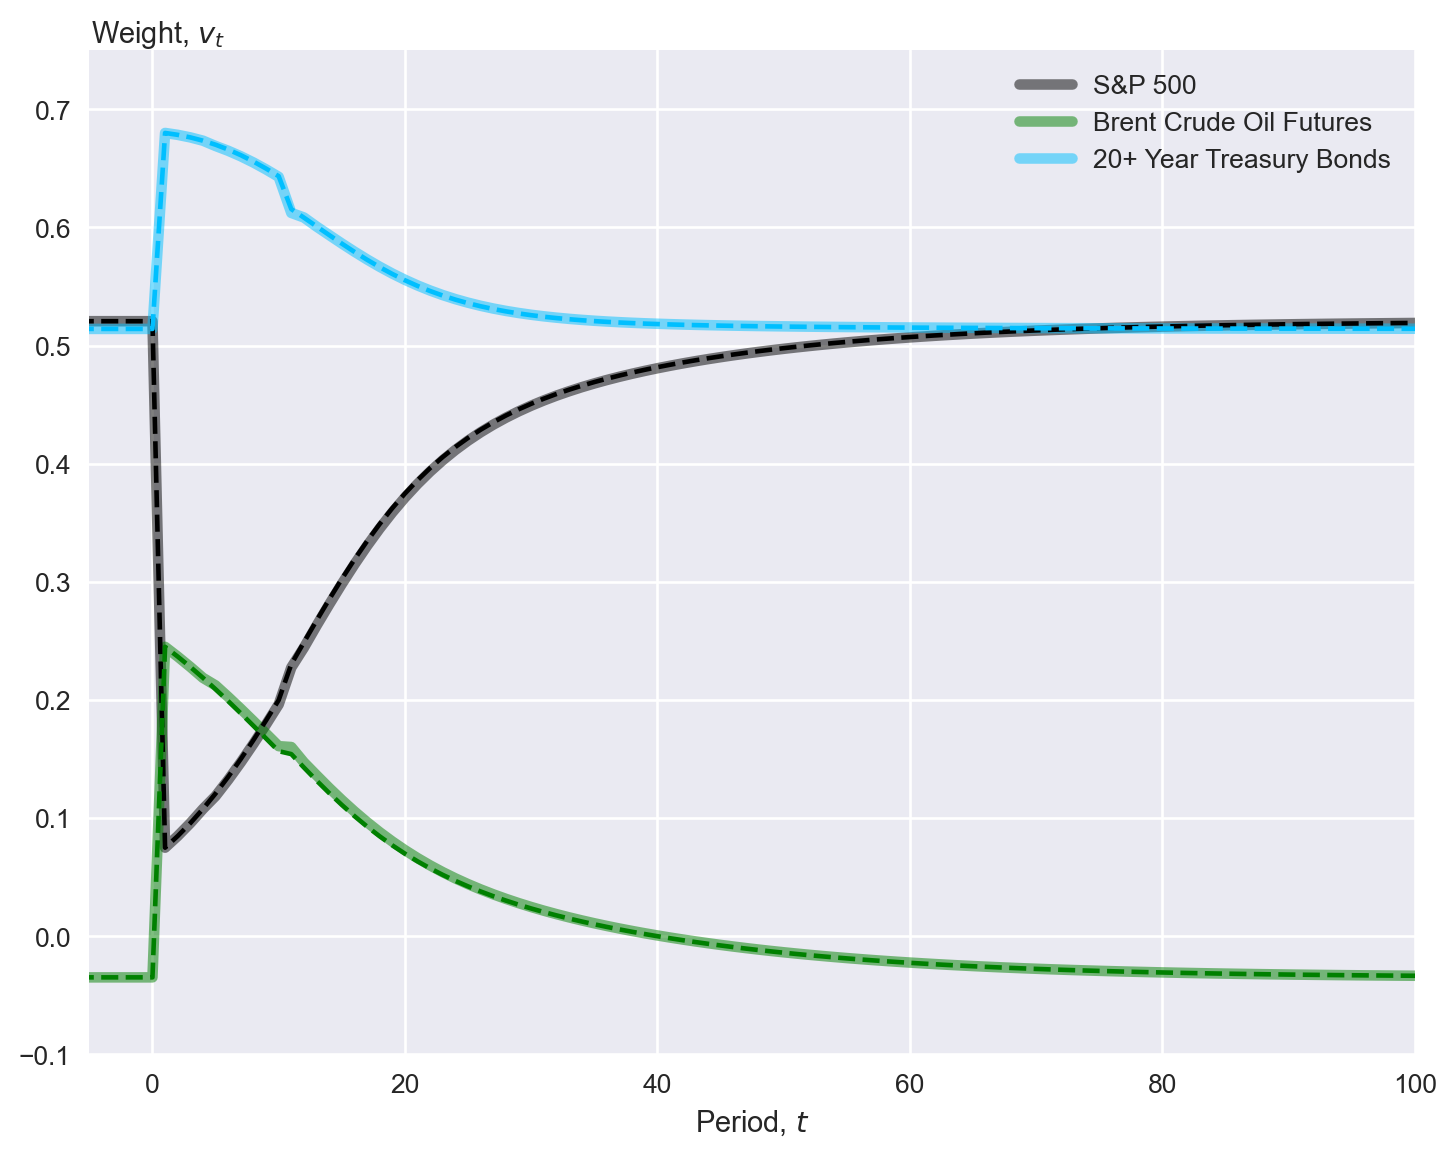

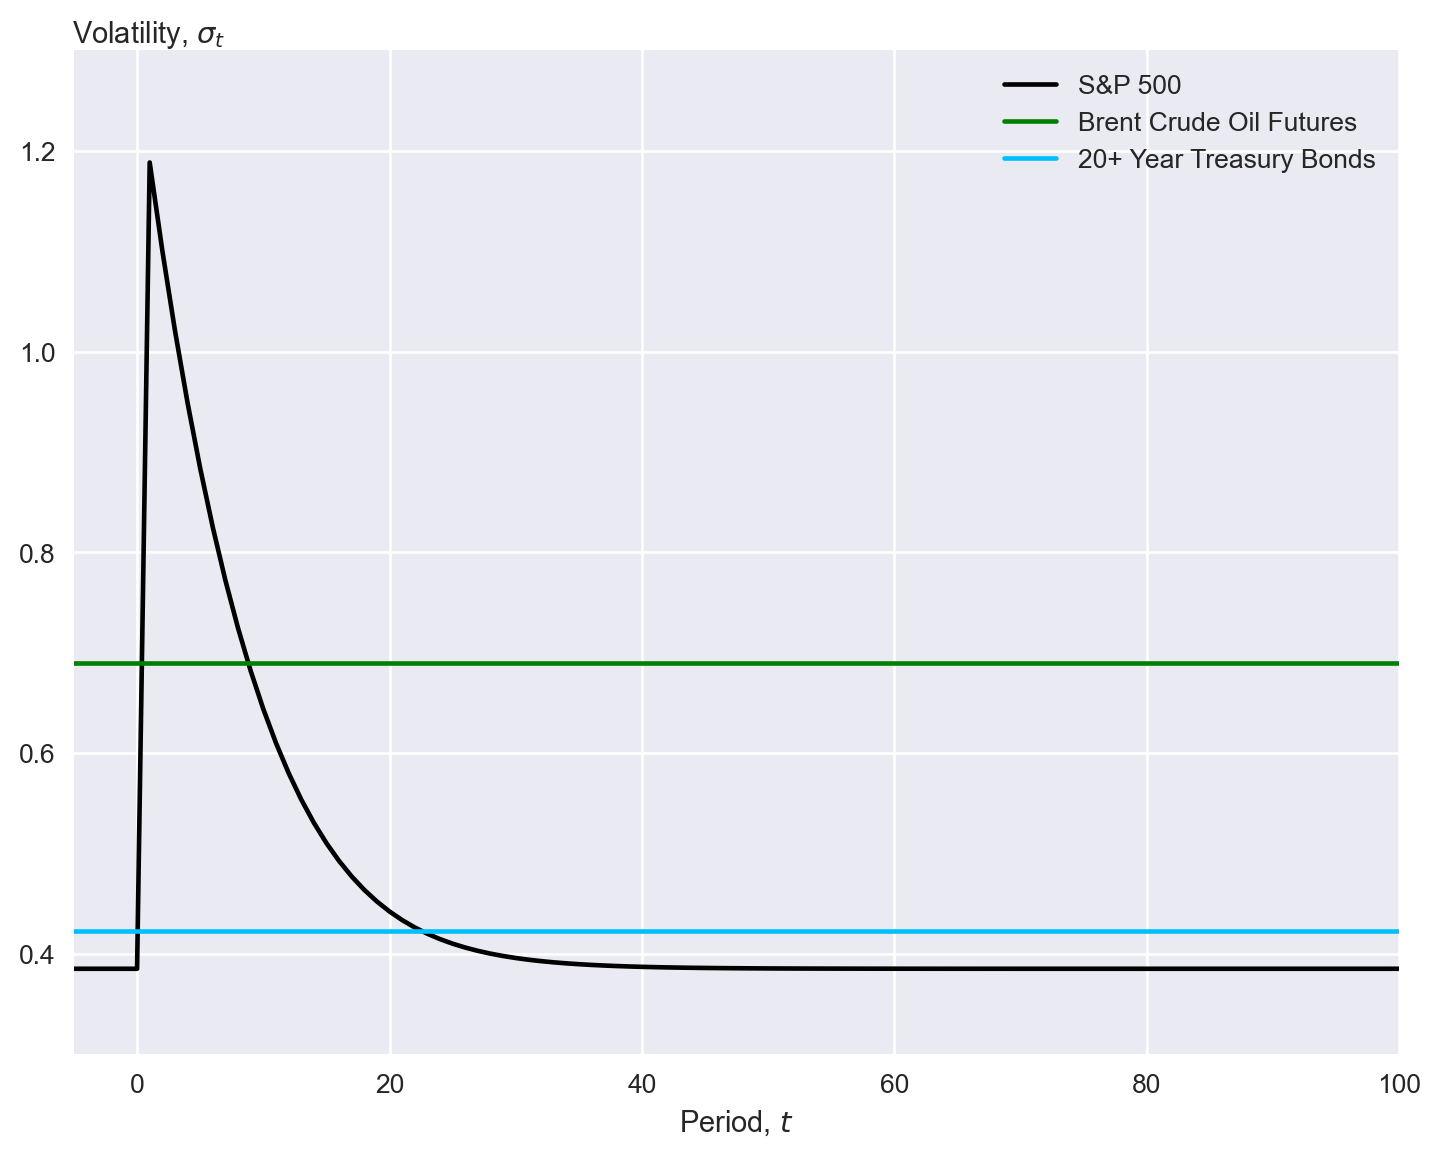

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.set_prop_cycle(matplotlib.cycler(color=["black", "green",  "deepskyblue",]))
ax.plot(irf_weights_TC_GJRGARCH,linestyle="-",alpha=0.5,linewidth=4)
ax.plot(irf_aim_TC_GJRGARCH,linestyle="--")
ax.set_ylim(-0.1,0.75)
ax.set_xlim(-5,100)
ax.legend(included_asset_TC.values(), loc='upper right')
ax.set_xlabel('Period, $t$') 
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -78) 
fig.savefig("IRF_GJRGARCH(1,1)_weight_TC_low.png", bbox_inches = 'tight', pad_inches = 0.1)
#fig.savefig("IRF_GJRGARCH(1,1)_weight_TC_medium.png", bbox_inches = 'tight', pad_inches = 0.1)
#fig.savefig("IRF_GJRGARCH(1,1)_weight_TC_high.png", bbox_inches = 'tight', pad_inches = 0.1)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax1.plot(np.sqrt(irf_sigma_TC_GJRGARCH))
ax1.set_ylim(0.3,1.3)
ax1.set_xlim(-5,100)
ax1.legend(included_asset_TC.values(), loc='upper right')
ax1.set_xlabel('Period, $t$') 
ax1.set_ylabel('Volatility, $\sigma_t$',loc='top', rotation = 0, labelpad = -78)
#fig1.savefig("IRF_GJRARCH(1)_vol_TC.png", bbox_inches = 'tight', pad_inches = 0.1)